### Carga de librerias

In [30]:
%pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 1.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [60]:
%pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 631.5 kB/s eta 0:00:000:0100:06m
Note: you may need to restart the kernel to use updated packages.


In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.legend_handler import HandlerBase
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
#import mungo as msno

# Library to perform Statistical Analysis.
from scipy import stats
from scipy.stats import chi2
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

import imblearn
from imblearn.over_sampling import SMOTE

from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#import kds

In [7]:
df_cros = pd.read_csv("../data/raw/test.csv").set_index("id")
df_cros = df_cros.rename(columns={"Response":"Compraron"})

In [8]:
df_cros.shape

(127037, 10)

In [9]:
df_cros.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
id,,,,,,,,,,
381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [4]:
#Usar la etiqueta proporcionada en el conjunto de datos para convertir una columna discreta en una columna categórica
df_cros["Driving_License"] = df_cros["Driving_License"].replace({0:"No",1:"Yes"})
df_cros["Previously_Insured"] = df_cros["Previously_Insured"].replace({0:"No",1:"Yes"})
df_cros["Compraron"] = df_cros["Compraron"].replace({0:"No",1:"Yes"})

### Analisis de variables categoricas vs variable objetivo (compraron)

In [5]:
# Creando una función para visualización
def pie_bar_plot(df, col, hue):
    plt.figure(figsize=(10, 4))
    
    # Extraer recuentos de valores para la columna especificada
    col_counts = df[col].value_counts().sort_index()
    
    # Primera subtrama: gráfico circular
    plt.subplot(1, 2, 1) 
    ax1 = col_counts
    plt.title(f"Distribution by {col}", fontweight="black", size=10, pad=11)
    colors = sns.color_palette('husl', len(ax1))#Set2
    plt.pie(ax1.values, labels=ax1.index, autopct="%.1f%%", pctdistance=0.75, startangle=90, 
            colors=colors, textprops={"size":14})
    center_circle = plt.Circle((0, 0), 0.4, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(center_circle)
    
    # Segunda subtrama: diagrama de barras
    plt.subplot(1, 2, 2)
    new_df = df[df[hue] == 'Yes']
    value_1 = col_counts
    value_2 = new_df[col].value_counts().sort_index()  # Ordenar los valores en el mismo orden.
    ax2 = np.round((value_2 / value_1) * 100, 1).values
    sns.barplot(x=value_2.index, y=value_2.values, palette='Set2')
    plt.title(f"Employee Opting for Insurance by {col}", fontweight="black", size=10, pad=11)
    for index, value in enumerate(value_2):
        plt.text(index, value, str(value) + " (" + str(float(ax2[index])) + "% )", ha="center", va="bottom", size=10)

    plt.tight_layout()
    plt.show()

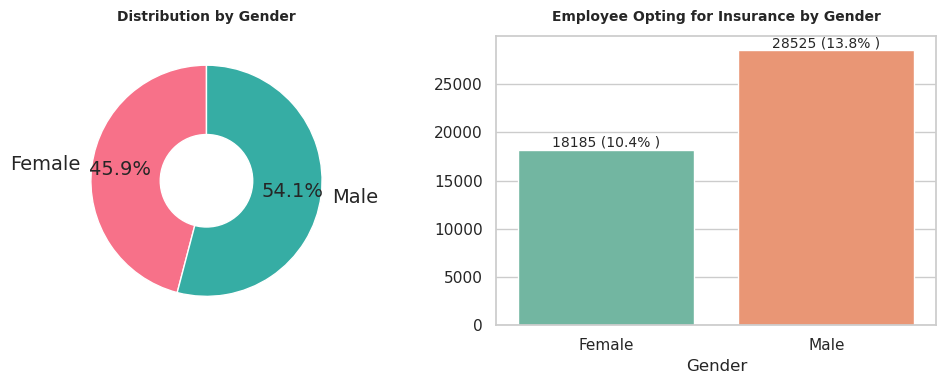

In [6]:
#Análisis del seguro de vehículos de los clientes por género
pie_bar_plot(df_cros, 'Gender', 'Compraron')

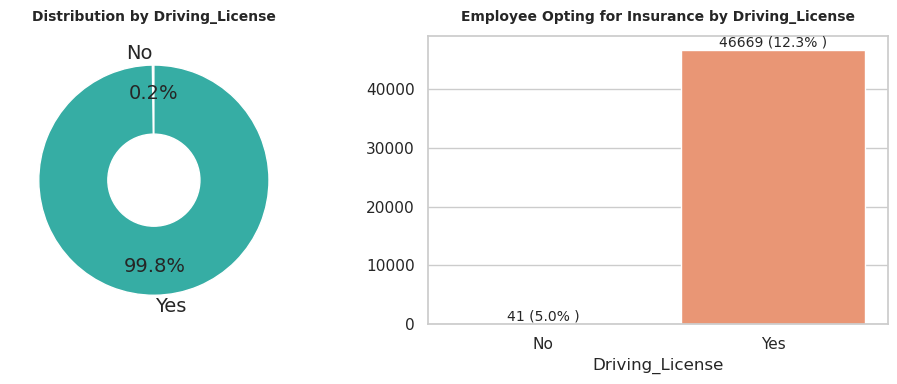

In [7]:
pie_bar_plot(df_cros, 'Driving_License', 'Compraron')

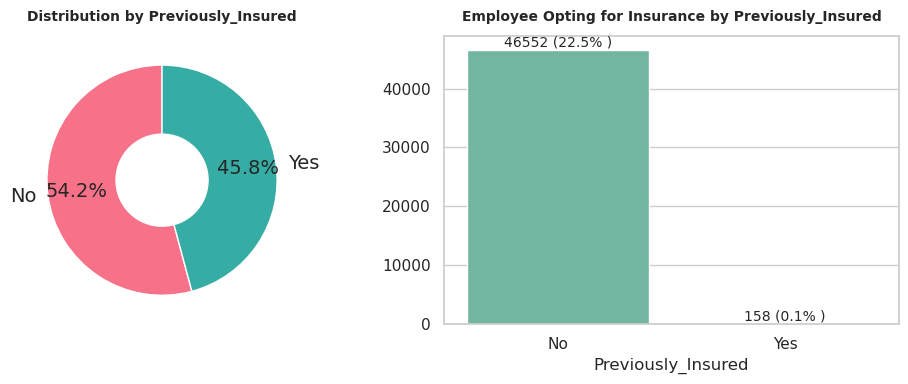

In [8]:
pie_bar_plot(df_cros, 'Previously_Insured', 'Compraron')

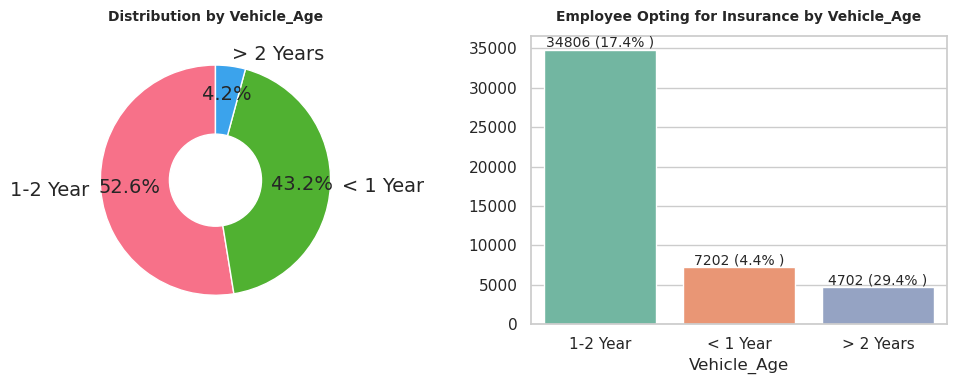

In [9]:
pie_bar_plot(df_cros, 'Vehicle_Age', 'Compraron')

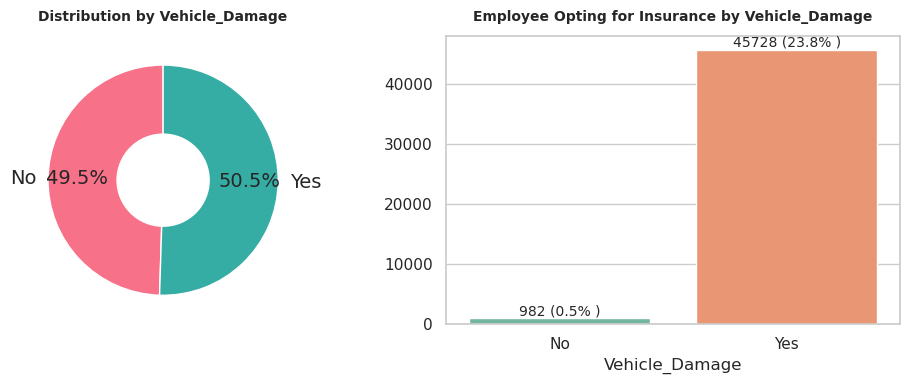

In [10]:
pie_bar_plot(df_cros, 'Vehicle_Damage', 'Compraron')

### Analisis de variables numericas vs variable objetivo (compraron)

In [11]:
def dist_box_plot(df, col, hue):   
    plt.rcParams['figure.figsize'] = (8, 4)
    sns.boxplot(x=df[col],y=df[hue], palette = 'husl')
    plt.title(f'Relación entre {col} y {hue}', fontsize = 20)
    plt.show()

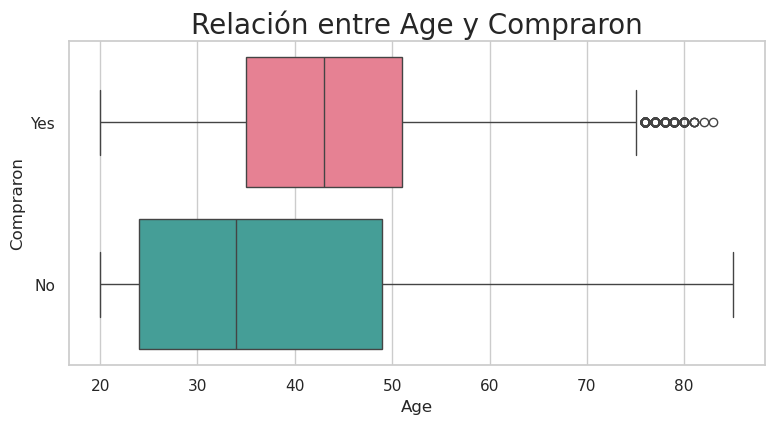

In [12]:
dist_box_plot(df_cros, 'Age', 'Compraron')

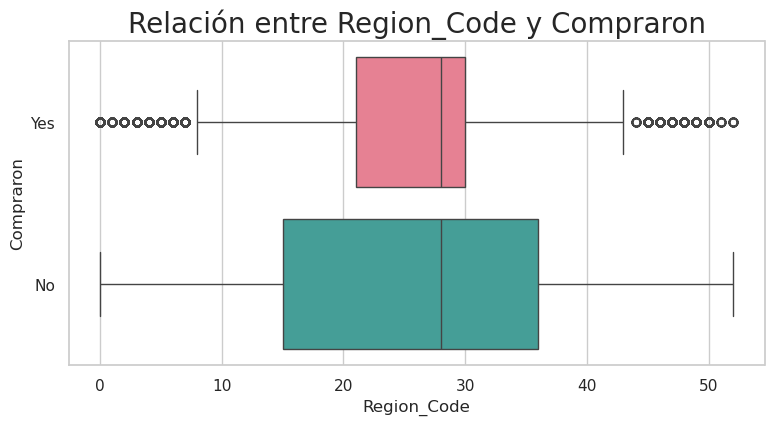

In [13]:
dist_box_plot(df_cros, 'Region_Code', 'Compraron')

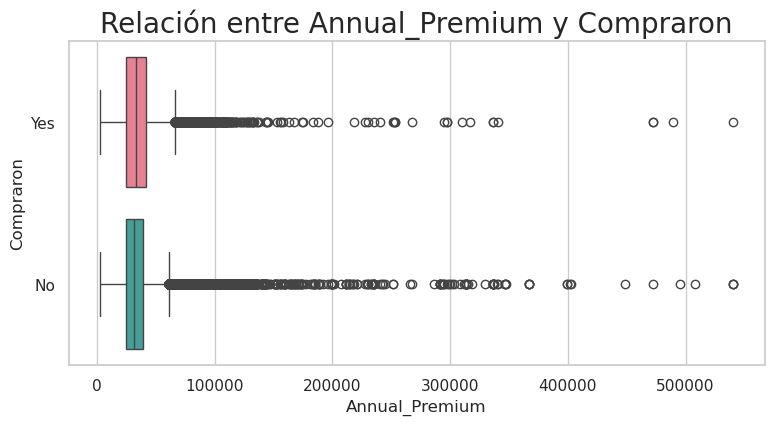

In [14]:
dist_box_plot(df_cros, 'Annual_Premium', 'Compraron')

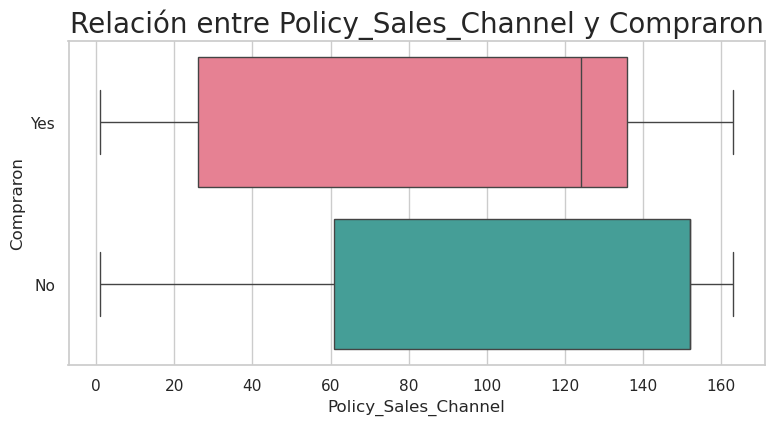

In [15]:
dist_box_plot(df_cros, 'Policy_Sales_Channel', 'Compraron')

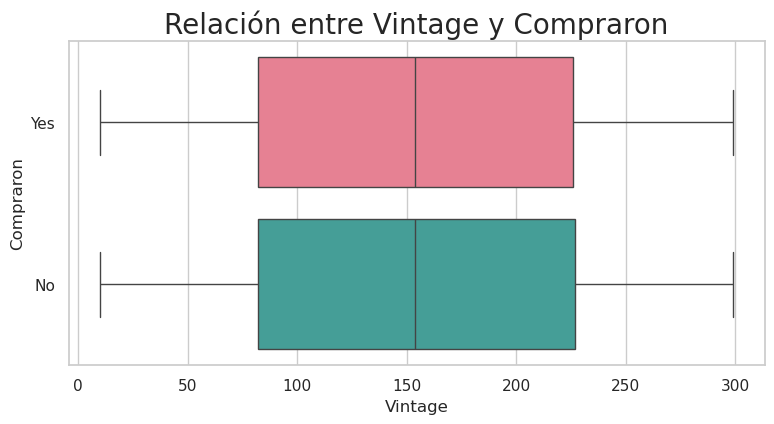

In [16]:
dist_box_plot(df_cros, 'Vintage', 'Compraron')

### Importancia de las variables

##### Realización de una prueba de chi-cuadrado para analizar la importancia de la característica categórica.

In [17]:
def plot_importance_cagorical(data):
    cat_cols = data.select_dtypes(include="object").columns.tolist()
    cat_cols.remove("Compraron")    # Removing Target Variable
    
    chi2_statistic = {}
    p_values = {}
    
    # Perform chi-square test for each column
    for col in cat_cols:
        contingency_table = pd.crosstab(data[col], data['Compraron'])
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        chi2_statistic[col] = chi2
        p_values[col] = p_value
        
    columns = list(chi2_statistic.keys())
    values = list(chi2_statistic.values())
    
    plt.figure(figsize=(13.5,6))
    palette = sns.color_palette("husl", len(columns))
    sns.barplot(x=columns, y=values,palette=palette)
    plt.xticks(rotation=90)
    plt.title("Chi_Square Stats Value of each Categorical Columns",fontweight="black",size=14,pad=15)
    for index,value in enumerate(values):
        plt.text(index,value,round(value,2),ha="center",va="bottom",size=12)
    
    plt.show()
    
    chi_data = pd.DataFrame({"Features":columns,"Chi_2 Statistic":values})
    chi_data["P_value"] =  [format(p, '.20f') for p in list(p_values.values())]   # P square value upto 20 decimal
    print(chi_data.head())

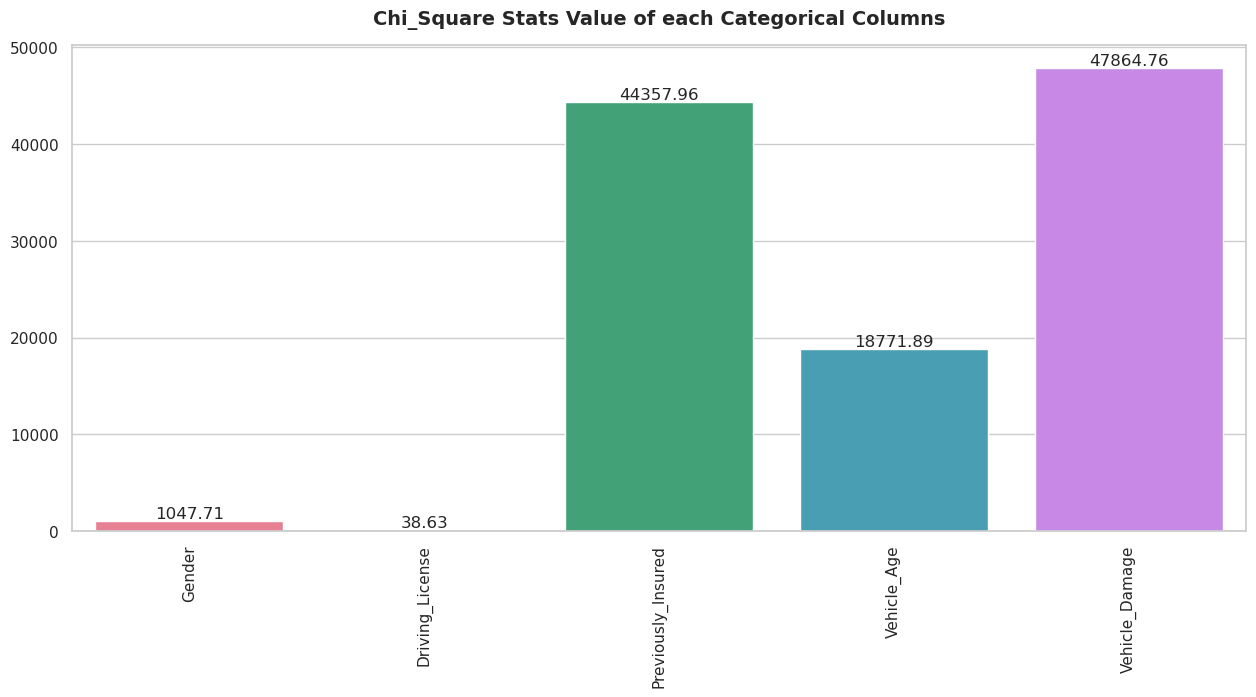

             Features  Chi_2 Statistic                 P_value
0              Gender      1047.707758  0.00000000000000000000
1     Driving_License        38.634117  0.00000000051117535040
2  Previously_Insured     44357.964722  0.00000000000000000000
3         Vehicle_Age     18771.889904  0.00000000000000000000
4      Vehicle_Damage     47864.761801  0.00000000000000000000


In [18]:
plot_importance_cagorical(df_cros)

##### Realización de una prueba de chi-cuadrado para analizar la importancia de la característica numericas.

In [19]:
def plot_importance_categorical(data):
    new_data = data.copy()
    new_data["Compraron"] = new_data["Compraron"].replace({"No":0,"Yes":1})
    
    num_cols = data.select_dtypes(np.number).columns
    
    f_scores = {}
    p_values = {}
    
    for column in num_cols:
        f_score, p_value = stats.f_oneway(new_data[column],new_data["Compraron"])
        
        f_scores[column] = f_score
        p_values[column] = p_value
        
    
    plt.figure(figsize=(13.5,6))
    keys = list(f_scores.keys())
    values = list(f_scores.values())
    palette = sns.color_palette("husl", len(keys))
    sns.barplot(x=keys, y=values, palette=palette)
    plt.title("Anova-Test F_scores Comparison", fontweight="black", size=14, pad=15)
    plt.xticks(rotation=90)
    
    for index,value in enumerate(values):
        plt.text(index,value,int(value), ha="center", va="bottom", size=12)
    plt.show()
    
    annova_data = pd.DataFrame({"Features":keys,"F_Score":values})
    annova_data["P_value"] = [format(p, '.20f') for p in list(p_values.values())]
    print(annova_data.head())

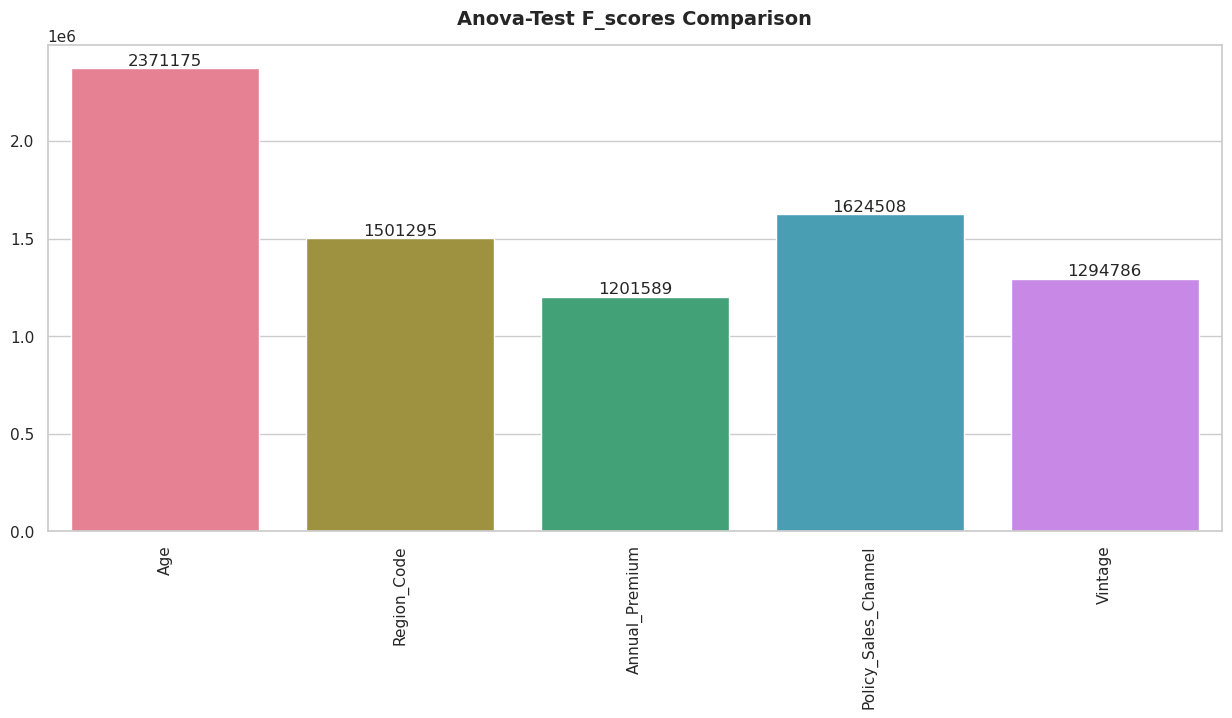

               Features       F_Score                 P_value
0                   Age  2.371176e+06  0.00000000000000000000
1           Region_Code  1.501295e+06  0.00000000000000000000
2        Annual_Premium  1.201590e+06  0.00000000000000000000
3  Policy_Sales_Channel  1.624508e+06  0.00000000000000000000
4               Vintage  1.294786e+06  0.00000000000000000000


In [20]:
plot_importance_categorical(df_cros)

### Encoding

In [21]:
#Codificar la variable de nuevo a su forma original
#Reemplazar 0 con 'No' y 1 con 'Sí' en 'Permiso_de_conducción', 'Asegurado_previamente' y 'Respuesta'
df_cros["Driving_License"] = df_cros["Driving_License"].replace({"No":0,"Yes":1})
df_cros["Previously_Insured"] = df_cros["Previously_Insured"].replace({"No":0,"Yes":1})
df_cros["Compraron"] = df_cros["Compraron"].replace({"No":0,"Yes":1})

In [22]:
df_cros.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Compraron
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [23]:
#Label Encoding
le = LabelEncoder()

In [24]:
df_cros['Gender'] = le.fit_transform(df_cros['Gender'])
df_cros['Vehicle_Damage'] = le.fit_transform(df_cros['Vehicle_Damage'])
df_cros.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Compraron
id,,,,,,,,,,,
1,1,44,1,28.0,0,> 2 Years,1,40454.0,26.0,217,1
2,1,76,1,3.0,0,1-2 Year,0,33536.0,26.0,183,0
3,1,47,1,28.0,0,> 2 Years,1,38294.0,26.0,27,1
4,1,21,1,11.0,1,< 1 Year,0,28619.0,152.0,203,0
5,0,29,1,41.0,1,< 1 Year,0,27496.0,152.0,39,0


In [25]:
#Ordinal Encoding
df_cros["Vehicle_Age"] = df_cros["Vehicle_Age"].replace({"< 1 Year":0,"1-2 Year":1, "> 2 Years":2})
df_cros.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Compraron
id,,,,,,,,,,,
1,1,44,1,28.0,0,2,1,40454.0,26.0,217,1
2,1,76,1,3.0,0,1,0,33536.0,26.0,183,0
3,1,47,1,28.0,0,2,1,38294.0,26.0,27,1
4,1,21,1,11.0,1,0,0,28619.0,152.0,203,0
5,0,29,1,41.0,1,0,0,27496.0,152.0,39,0


### Correlacion

In [21]:
#Age
#Region_Code
#Annual_Premium
#Policy_Sales_Channel
#Vintage

<Axes: >

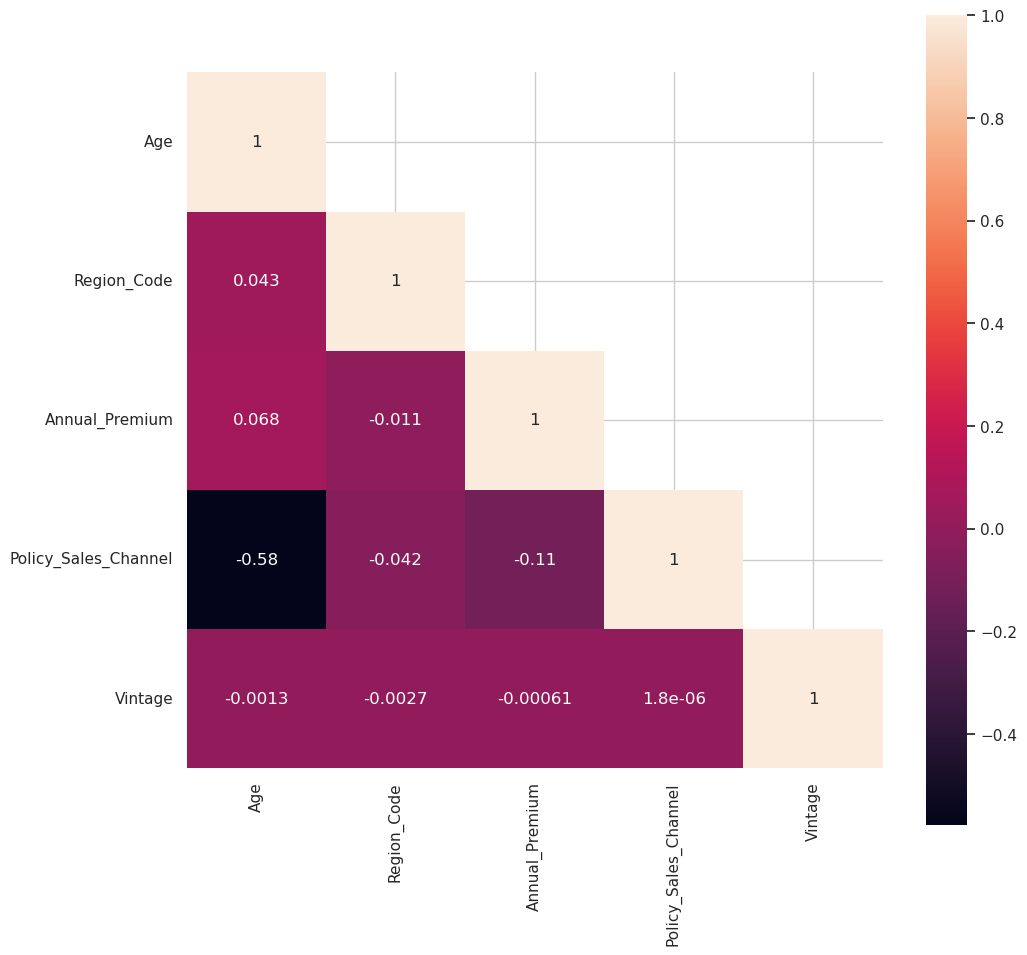

In [26]:
## Matriz de corelaciones
cor_mat = df_cros[['Age','Region_Code','Annual_Premium','Policy_Sales_Channel','Vintage']].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(10,10)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

### Balanceo de data usando SMOTE

In [27]:
x = df_cros.drop(['Compraron'], axis=1)
y = df_cros[['Compraron']]

In [28]:
x.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
id,,,,,,,,,,
1,1,44,1,28.0,0,2,1,40454.0,26.0,217
2,1,76,1,3.0,0,1,0,33536.0,26.0,183
3,1,47,1,28.0,0,2,1,38294.0,26.0,27
4,1,21,1,11.0,1,0,0,28619.0,152.0,203
5,0,29,1,41.0,1,0,0,27496.0,152.0,39


In [29]:
y.head()

,Compraron
id,
1,1
2,0
3,1
4,0
5,0


In [30]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x,y)
print(y.value_counts())
print()
print(y_smote.value_counts())

Compraron
0            334399
1             46710
Name: count, dtype: int64

Compraron
0            334399
1            334399
Name: count, dtype: int64


In [31]:
x_smote

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,1,44,1,28.000000,0,2,1,40454.000000,26.000000,217
1,1,76,1,3.000000,0,1,0,33536.000000,26.000000,183
2,1,47,1,28.000000,0,2,1,38294.000000,26.000000,27
3,1,21,1,11.000000,1,0,0,28619.000000,152.000000,203
4,0,29,1,41.000000,1,0,0,27496.000000,152.000000,39
...,...,...,...,...,...,...,...,...,...,...
668793,0,46,1,13.056015,0,1,1,30224.471993,124.000000,273
668794,1,53,1,34.336212,0,1,1,38810.431039,26.000000,257
668795,0,53,1,15.884920,0,1,1,2630.000000,156.115080,136
668796,1,48,1,28.000000,0,1,1,35168.179239,26.000000,192


In [32]:
y_smote

,Compraron
0,1
1,0
2,1
3,0
4,0
...,...
668793,1
668794,1
668795,1
668796,1


### Scalado de variables o caracteristicas

In [45]:
scaler = StandardScaler()

In [46]:
x_smote.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,1,44,1,28.0,0,2,1,40454.0,26.0,217
1,1,76,1,3.0,0,1,0,33536.0,26.0,183
2,1,47,1,28.0,0,2,1,38294.0,26.0,27
3,1,21,1,11.0,1,0,0,28619.0,152.0,203
4,0,29,1,41.0,1,0,0,27496.0,152.0,39


In [47]:
x_scaled = scaler.fit_transform(x_smote)
data_scaled = scaler.fit_transform(df_cros)

In [49]:
x_scaled

array([[ 1.06373492,  0.24878193,  0.04419927, ...,  0.53119482,
        -1.38589709,  0.75742752],
       [ 1.06373492,  2.57215472,  0.04419927, ...,  0.14194949,
        -1.38589709,  0.34843568],
       [ 1.06373492,  0.46659813,  0.04419927, ...,  0.40966115,
        -1.38589709, -1.52811513],
       ...,
       [-0.94008383,  0.24878193,  0.04419927, ...,  0.25783611,
         1.04592478, -1.27550252],
       [-0.94008383, -0.69508827,  0.04419927, ...,  0.94018795,
         0.78279623,  0.5529316 ],
       [-0.94008383,  0.10357113,  0.04419927, ..., -0.34216239,
        -1.38589709,  1.22656523]])

In [50]:
data_scaled

array([[ 0.92154476,  0.33377727,  0.04620794, ..., -1.58723371,
         0.74879538,  2.67563921],
       [ 0.92154476,  2.39675074,  0.04620794, ..., -1.58723371,
         0.34244286, -0.37374247],
       [ 0.92154476,  0.52718104,  0.04620794, ..., -1.58723371,
        -1.52199808,  2.67563921],
       ...,
       [ 0.92154476, -1.14898491,  0.04620794, ...,  0.88491205,
         0.07950888, -0.37374247],
       [-1.08513449,  1.88100737,  0.04620794, ...,  0.22075349,
        -0.96027549, -0.37374247],
       [ 0.92154476,  0.46271311,  0.04620794, ..., -1.58723371,
         0.98782627, -0.37374247]])

### Factor de inflación de varianza

In [52]:
variable = x_scaled
vif = pd.DataFrame()
vif["factor_inflacion_varianza"] = [variance_inflation_factor(variable, i) for i in range(variable.shape[1])]
vif["variables"] = x.columns
vif

,factor_inflacion_varianza,variables
0,1.015802,Gender
1,2.308776,Age
2,1.005344,Driving_License
3,1.002673,Region_Code
4,3.353437,Previously_Insured
5,2.311814,Vehicle_Age
6,3.390821,Vehicle_Damage
7,1.032781,Annual_Premium
8,1.492987,Policy_Sales_Channel
9,1.000095,Vintage


### Divida los datos en entrenamiento y prueba (sin escalar)

In [55]:
x_train, x_test, y_train,y_test = train_test_split(x_smote,y_smote,test_size=0.3, random_state=42)

In [56]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(468158, 10) (468158, 1) (200640, 10) (200640, 1)


### Divida los datos en entrenamiento y prueba (scalar)

In [57]:
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(x_scaled,y_smote,test_size=0.3,random_state=42)
print(x_train_scaled.shape,x_test_scaled.shape,y_train_scaled.shape,y_test_scaled.shape)

(468158, 10) (200640, 10) (468158, 1) (200640, 1)


### Importación de bibliotecas necesarias para la construcción de modelos

In [62]:
from sklearn import metrics
from sklearn.metrics import *
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import randint
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

### Construcción del modelo

In [83]:
training_score = []
testing_score = []
precision = []
recall = []
auc_score = []

In [67]:
def model_prediction_sacaled(model):
    model.fit(x_train_scaled,y_train_scaled)
    x_train_pred1 = model.predict(x_train_scaled)
    x_test_pred1 = model.predict(x_test_scaled)
    y_test_prob1 = model.predict_proba(x_test_scaled)[:, 1]
    a = accuracy_score(y_train_scaled,x_train_pred1)*100
    b = accuracy_score(y_test_scaled,x_test_pred1)*100
    c = precision_score(y_test_scaled,x_test_pred1)
    d = recall_score(y_test_scaled,x_test_pred1)
    e = roc_auc_score(y_test_scaled, y_test_prob1)
    training_score.append(a)
    testing_score.append(b)
    precision.append(c)
    recall.append(d)
    auc_score.append(e)
    
    
    print(f"Accuracy_Score of {model} model on Training Data is:",a)
    print(f"Accuracy_Score of {model} model on Testing Data is:",b)
    print("\n------------------------------------------------------------------------")
    print(f"Precision Score of {model} model is:",c)
    print(f"Recall Score of {model} model is:",d)
    print(f"AUC Score of {model} model is:", e)
    print("\n------------------------------------------------------------------------")
    print(f"Confusion Matrix of {model} model is:")
    cm = confusion_matrix(y_test_scaled,x_test_pred1)
    plt.figure(figsize=(8,4))
    sns.heatmap(cm,annot=True,fmt="g",cmap="summer")
    plt.show()
    
    print("\n------------------------------------------------------------------------")
    print(f"ROC - AUC Curve of {model} model is:")
    y_pred_proba1 = model.predict_proba(x_test_scaled)[:][:,1]
    fpr, tpr, thresholds = roc_curve(y_test_scaled, y_pred_proba1)
    auc = roc_auc_score(y_test_scaled, y_pred_proba1)

    plt.figure(figsize=(8, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}",color="green")
    plt.plot([0, 1], [0, 1], linestyle="--", color="black")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve",pad=20,fontweight="black")
    plt.legend()
    plt.show()

In [61]:
def model_prediction_unscaled(model):
    model.fit(x_train,y_train)
    x_train_pred = model.predict(x_train)
    x_test_pred = model.predict(x_test)
    y_test_prob = model.predict_proba(x_test)[:, 1]
    a = accuracy_score(y_train,x_train_pred)*100
    b = accuracy_score(y_test,x_test_pred)*100
    c = precision_score(y_test,x_test_pred)
    d = recall_score(y_test,x_test_pred)
    e = roc_auc_score(y_test, y_test_prob)
    training_score.append(a)
    testing_score.append(b)
    precision.append(c)
    recall.append(d)
    auc_score.append(e)
    
    print(f"Accuracy_Score of {model} model on Training Data is:",a)
    print(f"Accuracy_Score of {model} model on Testing Data is:",b)
    print("\n------------------------------------------------------------------------")
    print(f"Precision Score of {model} model is:",c)
    print(f"Recall Score of {model} model is:",d)
    print(f"AUC Score of {model} model is:", e)
    print("\n------------------------------------------------------------------------")
    print(f"Classification Report of {model} model is:")
    print(classification_report(y_test, model.predict(x_test)))
    print("\n------------------------------------------------------------------------")
    print(f"Confusion Matrix of {model} model is:")
    cm = confusion_matrix(y_test,x_test_pred)
    plt.figure(figsize=(8,4))
    sns.heatmap(cm,annot=True,fmt="g",cmap="summer")
    plt.show()
    print("\n------------------------------------------------------------------------")
    print(f"ROC - AUC Curve of {model} model is:")
    y_pred_proba = model.predict_proba(x_test)[:][:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)

    plt.figure(figsize=(8, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}",color="green")
    plt.plot([0, 1], [0, 1], linestyle="--", color="black")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve",pad=20,fontweight="black")
    plt.legend()
    plt.show()

### Logistic Regression

Accuracy_Score of LogisticRegression() model on Training Data is: 77.53472118387383
Accuracy_Score of LogisticRegression() model on Testing Data is: 77.84190590111642

------------------------------------------------------------------------
Precision Score of LogisticRegression() model is: 0.7031152602815186
Recall Score of LogisticRegression() model is: 0.9651954151078564
AUC Score of LogisticRegression() model is: 0.8363199674865012

------------------------------------------------------------------------
Confusion Matrix of LogisticRegression() model is:


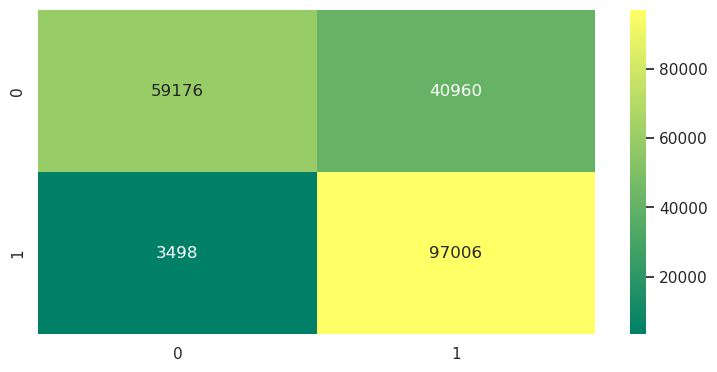


------------------------------------------------------------------------
ROC - AUC Curve of LogisticRegression() model is:


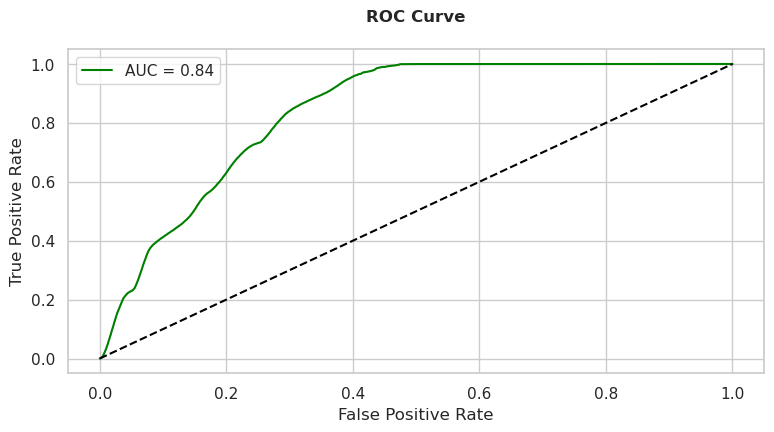

In [84]:
model_prediction_sacaled(LogisticRegression())

### Decision Tree

Accuracy_Score of DecisionTreeClassifier() model on Training Data is: 99.98291175201534
Accuracy_Score of DecisionTreeClassifier() model on Testing Data is: 87.68590510366826

------------------------------------------------------------------------
Precision Score of DecisionTreeClassifier() model is: 0.8707723915276623
Recall Score of DecisionTreeClassifier() model is: 0.885596593170421
AUC Score of DecisionTreeClassifier() model is: 0.87695454347454

------------------------------------------------------------------------
Classification Report of DecisionTreeClassifier() model is:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88    100136
           1       0.87      0.89      0.88    100504

    accuracy                           0.88    200640
   macro avg       0.88      0.88      0.88    200640
weighted avg       0.88      0.88      0.88    200640


------------------------------------------------------------------------
Confusion

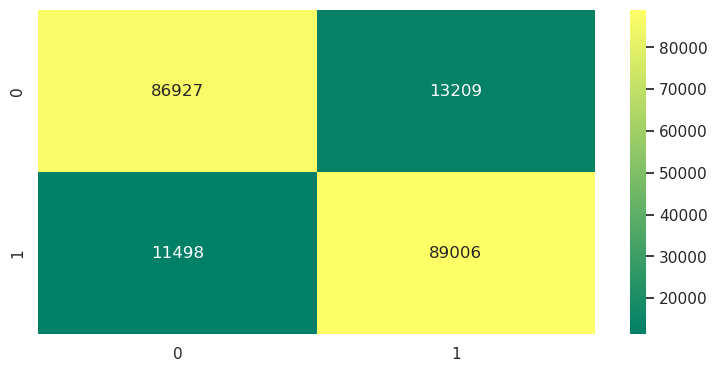


------------------------------------------------------------------------
ROC - AUC Curve of DecisionTreeClassifier() model is:


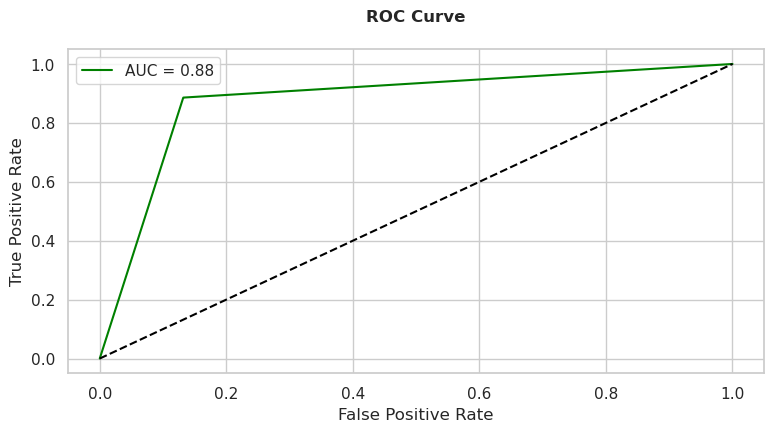

In [85]:
model_prediction_unscaled(DecisionTreeClassifier())

### Random Forest

Accuracy_Score of RandomForestClassifier() model on Training Data is: 99.98248454581574
Accuracy_Score of RandomForestClassifier() model on Testing Data is: 88.58751993620415

------------------------------------------------------------------------
Precision Score of RandomForestClassifier() model is: 0.8709655831739962
Recall Score of RandomForestClassifier() model is: 0.9064614343707713
AUC Score of RandomForestClassifier() model is: 0.9631977549257835

------------------------------------------------------------------------
Classification Report of RandomForestClassifier() model is:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88    100136
           1       0.87      0.91      0.89    100504

    accuracy                           0.89    200640
   macro avg       0.89      0.89      0.89    200640
weighted avg       0.89      0.89      0.89    200640


------------------------------------------------------------------------
Confus

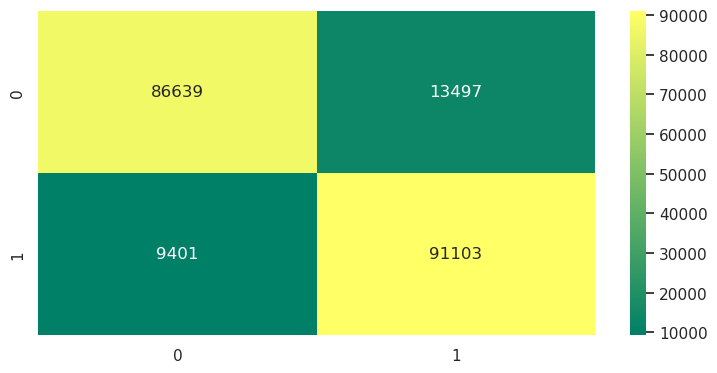


------------------------------------------------------------------------
ROC - AUC Curve of RandomForestClassifier() model is:


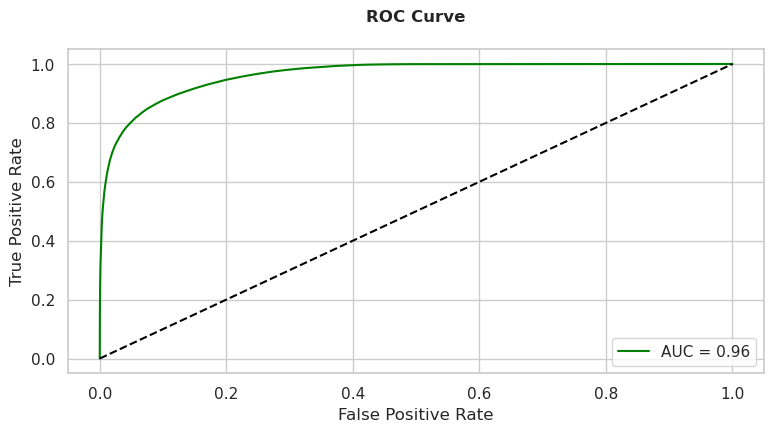

In [86]:
model_prediction_unscaled(RandomForestClassifier())

In [87]:
### AdaBoost

Accuracy_Score of AdaBoostClassifier() model on Training Data is: 82.72954857120887
Accuracy_Score of AdaBoostClassifier() model on Testing Data is: 82.96401515151514

------------------------------------------------------------------------
Precision Score of AdaBoostClassifier() model is: 0.7790033401482453
Recall Score of AdaBoostClassifier() model is: 0.9212568653983921
AUC Score of AdaBoostClassifier() model is: 0.9112218424294547

------------------------------------------------------------------------
Classification Report of AdaBoostClassifier() model is:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81    100136
           1       0.78      0.92      0.84    100504

    accuracy                           0.83    200640
   macro avg       0.84      0.83      0.83    200640
weighted avg       0.84      0.83      0.83    200640


------------------------------------------------------------------------
Confusion Matrix of AdaBoostCl

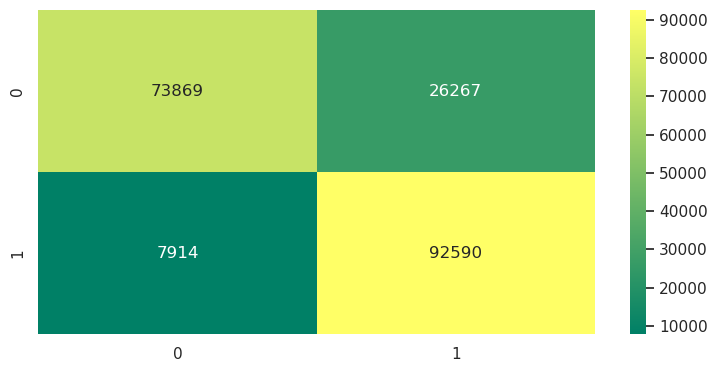


------------------------------------------------------------------------
ROC - AUC Curve of AdaBoostClassifier() model is:


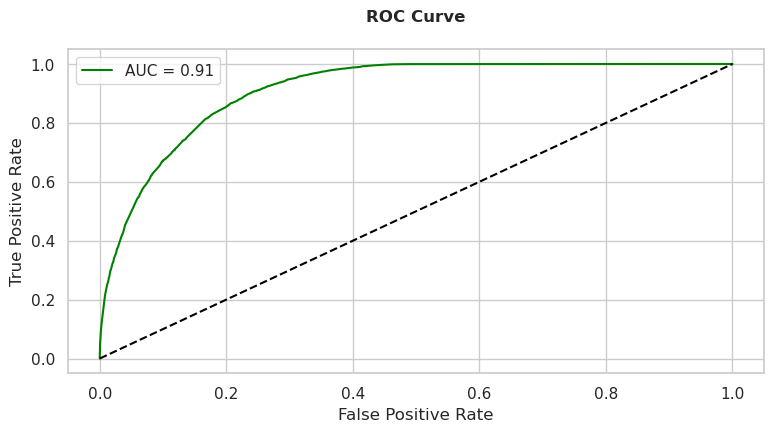

In [88]:
model_prediction_unscaled(AdaBoostClassifier())

In [89]:
### Gradient Boosting

Accuracy_Score of GradientBoostingClassifier() model on Training Data is: 84.14680513843616
Accuracy_Score of GradientBoostingClassifier() model on Testing Data is: 84.3151913875598

------------------------------------------------------------------------
Precision Score of GradientBoostingClassifier() model is: 0.7943729958381661
Recall Score of GradientBoostingClassifier() model is: 0.9267790336703017
AUC Score of GradientBoostingClassifier() model is: 0.931228111724991

------------------------------------------------------------------------
Classification Report of GradientBoostingClassifier() model is:
              precision    recall  f1-score   support

           0       0.91      0.76      0.83    100136
           1       0.79      0.93      0.86    100504

    accuracy                           0.84    200640
   macro avg       0.85      0.84      0.84    200640
weighted avg       0.85      0.84      0.84    200640


---------------------------------------------------------

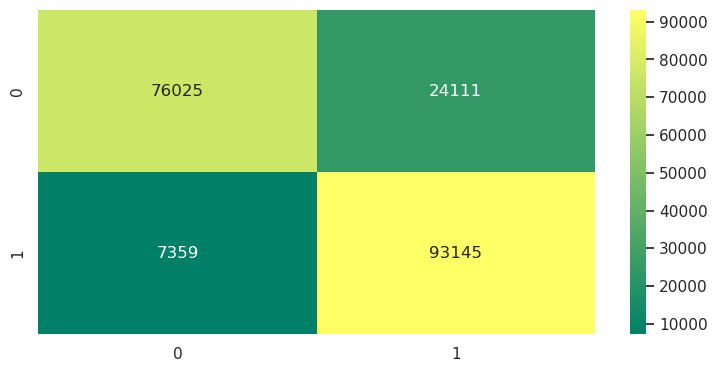


------------------------------------------------------------------------
ROC - AUC Curve of GradientBoostingClassifier() model is:


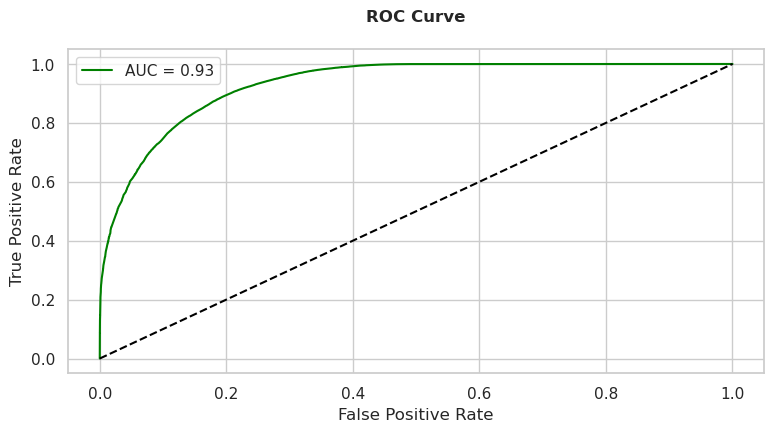

In [90]:
model_prediction_unscaled(GradientBoostingClassifier())

In [91]:
### XGBoost

Accuracy_Score of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) model on Training Data is: 86.8956634298677
Accuracy_Score of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, dev

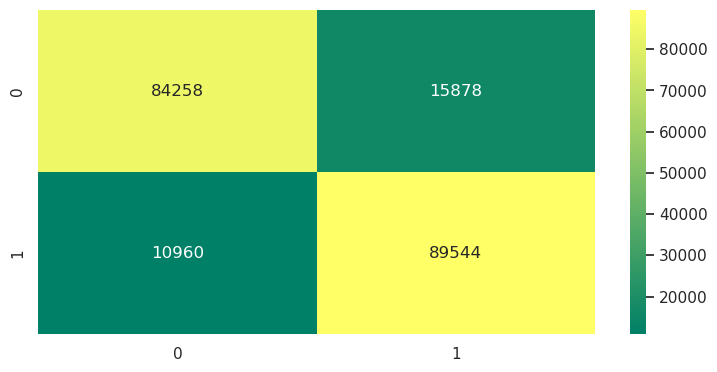


------------------------------------------------------------------------
ROC - AUC Curve of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) model is:


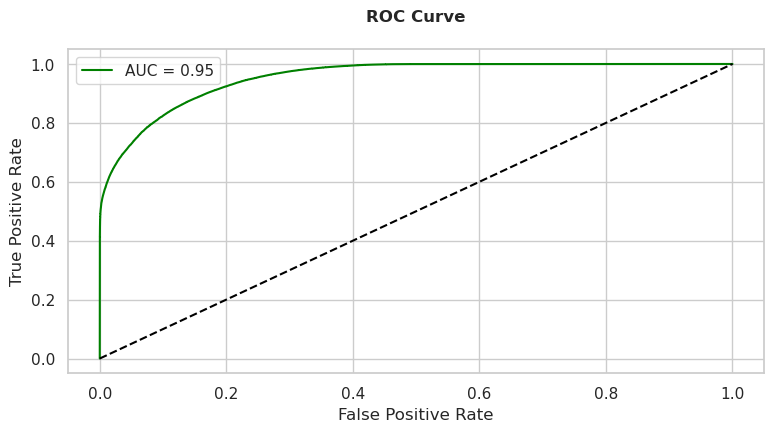

In [92]:
model_prediction_unscaled(XGBClassifier())

In [93]:
### Combinando el resultado en un marco de datos

In [94]:
models = ["Logistic Regression","Decision Tree","Random Forest","Ada Boost",
          "Gradient Boost","XGBoost"]

In [95]:
models

['Logistic Regression',
 'Decision Tree',
 'Random Forest',
 'Ada Boost',
 'Gradient Boost',
 'XGBoost']

In [96]:
training_score

[77.53472118387383,
 99.98291175201534,
 99.98248454581574,
 82.72954857120887,
 84.14680513843616,
 86.8956634298677]

In [97]:
df = pd.DataFrame({"Algorithms":models,
                   "Training Score":training_score,
                   "Testing Score":testing_score,
                  "Precision": precision,
                  "Recall": recall,
                  "AUC Score": auc_score})
df

,Algorithms,Training Score,Testing Score,Precision,Recall,AUC Score
0,Logistic Regression,77.534721,77.841906,0.703115,0.965195,0.836320
1,Decision Tree,99.982912,87.685905,0.870772,0.885597,0.876955
2,Random Forest,99.982485,88.587520,0.870966,0.906461,0.963198
3,Ada Boost,82.729549,82.964015,0.779003,0.921257,0.911222
4,Gradient Boost,84.146805,84.315191,0.794373,0.926779,0.931228
5,XGBoost,86.895663,86.623804,0.849386,0.890950,0.953098
